# PROBLEM DEFINITION
<p style='teData_lgdt-align: justify;'>As we will see in the below cells, a given dataset composed of two features entitled "SiteText" and "Sector". The "SiteText" column is composed of around 19000 records which are web-scrapped texts. The second column "Sector" indicates the corresponding sectors for those fields. As is shown it is a categorical feature and composed of very limited categories.</p>

<p style='teData_lgdt-align: justify;'>During this assignment, My main task will be establishing a model which can categorize the records of the "SiteText". Since the corresponding categories are given in the column "Sector", the problem under study will be a supervised-learning problem. Hence, I have to establish a machine-learning model that categories those text and compare the predicted categories with the existing answer in the Sector columns to calculate the accuracy of the established model.</p>

<p style='teData_lgdt-align: justify;'> Since the Sector column look very clan, it will not require a lots of work.  Effectively, my task will be detecting the language of text, translating it to the target language (if it is required), and then cleaning the text to be ready to vectorize the text and then applying the machine learning classifiers.</p>

<p style='teData_lgdt-align: justify;'> A given dataset is stored in CSV format and it is not bigdata type, hence it will be very efficient and handy to use Pandas library together with scikit-learn libraries. In some parts of the modeling, I will need to create a graph to convey my messages very easily (Normally graphs are easy to understand and they convey a lot of information just in one sight). To this end, I will use the seaborn library.</p>

<p style='teData_lgdt-align: justify;'>  as I mentioned, the most time-consuming part of the assignment will be exploring and cleaning those texts. To this end, Mostly I will use nltk library which is established for the purpose of Natural Language Processing.</p>


# IMPORTING REQUIRED LIBRARIES
<p style='teData_lgdt-align: justify;'> For the different parts of the following notebook, we will perform different applications, for this reason, we need to import required libraries from various libraries of the Python package. The below cell shows the list of required packages which we will use during this modeling procedure.</p>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from bs4 import BeautifulSoup

from autocorrect import Speller
import unidecode
from collections import Counter

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from google_trans_new import google_translator  

In [2]:
import warnings
warnings.simplefilter("ignore")

# READING THE DATASET
<p style='teData_lgdt-align: justify;'>Immediately after importing the required libraries, the next step is loading the dataset. Generally, the given dataset might include a huge number of entries, it might be very time-consuming to display it as a data frame table and get an insight about included features. A given dataset has a total of two features. Before building any machine learning model the data must be cleaned in an appropriate format. Hence, to collect the basic knowledge about the given dataset and the provided features, using the method "info" makes it much easier. Below, the cell shows how the info method can be applied to a given data frame and what information it provides as a result.</p>

In [3]:
data = pd.read_csv('CompanySectorData.csv', low_memory = False)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18326 entries, 0 to 18325
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   SiteText  18326 non-null  object
 1   Sector    18326 non-null  object
dtypes: object(2)
memory usage: 286.5+ KB


In [5]:
# It would be helpful to check if a given datafraeme has duplicated values or not. Below lines check the percentage
#of the duplicated rows and drop the them, accordingly.
print('The percentage of duplicated records is {:6.3}'.format(data.duplicated().mean()))
data = data.drop_duplicates()
print('The percentage of duplicated records is {:6.3}'.format(data.duplicated().mean()))

The percentage of duplicated records is 0.0785
The percentage of duplicated records is    0.0


# EXPLORING THE DATASET
<p style='teData_lgdt-align: justify;'>
As is shown above, a given dataset contains two columns entitled "SiteText" and "Sector". The sector columns are composed of a few categories. Utilizing a barplot the population of each category can be investigated. The below cell shows the barplot of the population of each category. </p>

<p style='teData_lgdt-align: justify;'>
At the first sight, the column "SiteText" looks pretty messy and complicated. Each record of the SiteText column is a web-scrapped text. Most likely, the texts are not from only a single language and there might be some of them. To recognize the contributed languages and count their population, I used the language detector function and the obtained populations are shown in the below cell.</p>

In [6]:
def get_lang(text):
    """
    This function return the language which the given text is written. It accepts a text and pass the name
    of the language. 
    
    Input type  : String
    Output type : String
    
    """
    import langdetect
    resu = None
    try:
        langs = langdetect.detect_langs(text)
        for language in langs:
            if resu is None or resu < language:
                resu = language
    except langdetect.lang_detect_exception.LangDetectException:
            pass
    if resu is None:
            return "nl"
    return resu.lang 

In [7]:
# In order to calculate the population of potential languages, first I will extract the corresponding languages
# then will put them in a new column under the title "Language". Hence, it will be the first feature extracted from
# a given dataset.

data['Language'] = data['SiteText'].apply(get_lang)

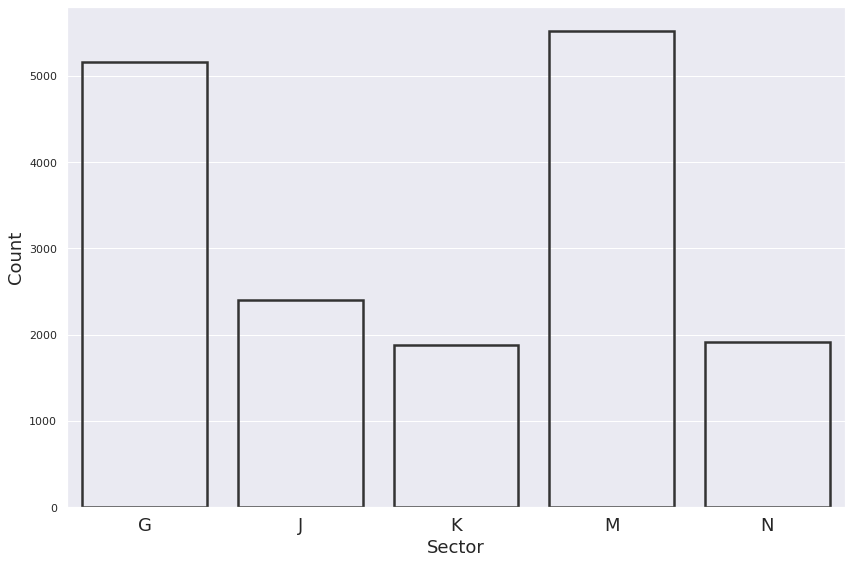

In [8]:
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize=((12,8)))

Sector_popu = data.groupby('Sector').count().reset_index()

ax = sns.barplot(x = "Sector", y = "SiteText", data = Sector_popu,
                 linewidth=2.5, facecolor=(1, 1, 1, 0), errcolor=".2", edgecolor=".2")
ax.set_xticklabels(Sector_popu['Sector'].tolist(), fontsize = 18)
ax.set_xlabel('Sector', fontsize = 18)
ax.set_ylabel('Count'   , fontsize = 18)
plt.tight_layout()
plt.show()

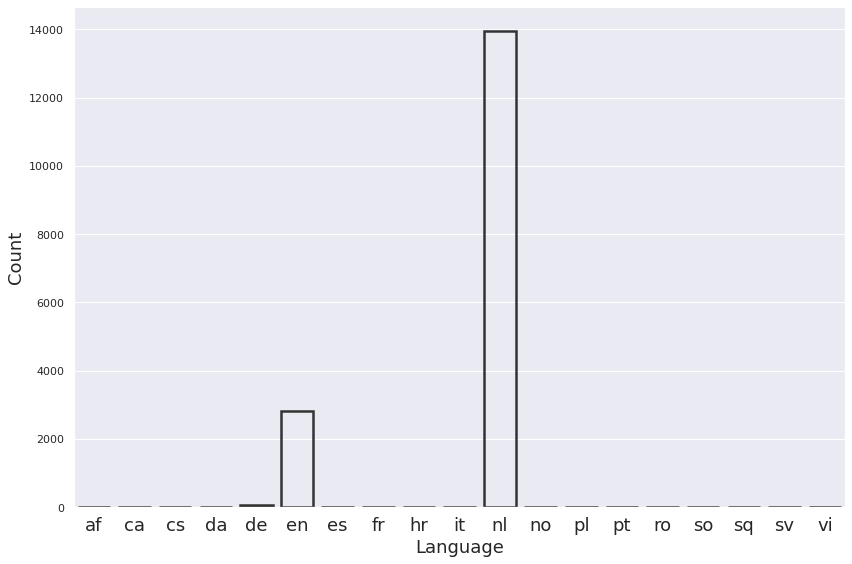

In [9]:
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize=((12,8)))

Language_popu = data.groupby('Language').count().reset_index()

ax = sns.barplot(x = "Language", y = "Sector", data = Language_popu,
                 linewidth=2.5, facecolor=(1, 1, 1, 0), errcolor=".2", edgecolor=".2")
ax.set_xticklabels(Language_popu['Language'].tolist(), fontsize = 18)
ax.set_xlabel('Language', fontsize = 18)
ax.set_ylabel('Count'   , fontsize = 18)
plt.tight_layout()
plt.show()

# SELECTING A SUB-DATASET 
<p style='teData_lgdt-align: justify;'>
Since the size of a given dataset is relatively large to be run on my laptop, I would sample around 25% of the full dataset to keep the computation fast as much as possible. One should note that it might affect the performance of the model (more solid prediction usually comes from a large pool of huge training data) and change the obtained results a little bit (for example, in the section of model selection it might change some parameter). But my approach to solving the problem and all of the details explained in the following remains intact.</p>

In [10]:
df1 = data.sample(frac = 1.0)
print('The size of selected community is {}'.format(len(df1)))

The size of selected community is 16888


# CHEKING FOR THE IMBALANCE OF CATEGORIES IN SECTOR FIELD 
Since the Sector column will be used as a label for supervised machine learning, it is worth checking if the sub-categories selected from the above cell are imbalanced or not? If not, then we can go ahead but if they are imbalanced, we have to balance them because the supervised machine learning algorithms which will be used are sensitive for the imbalanced classes. It is worth mentioning that there are a few well-known methods to deal with the imbalanced dataset which I only will remind some of them.

1. Undersampling of majority
2. Overesampling of Minority
3. SMOTE

Here, for the sake of simplicity, I only considered the Undersampling of majorities which are schematically shown in the below graph. 

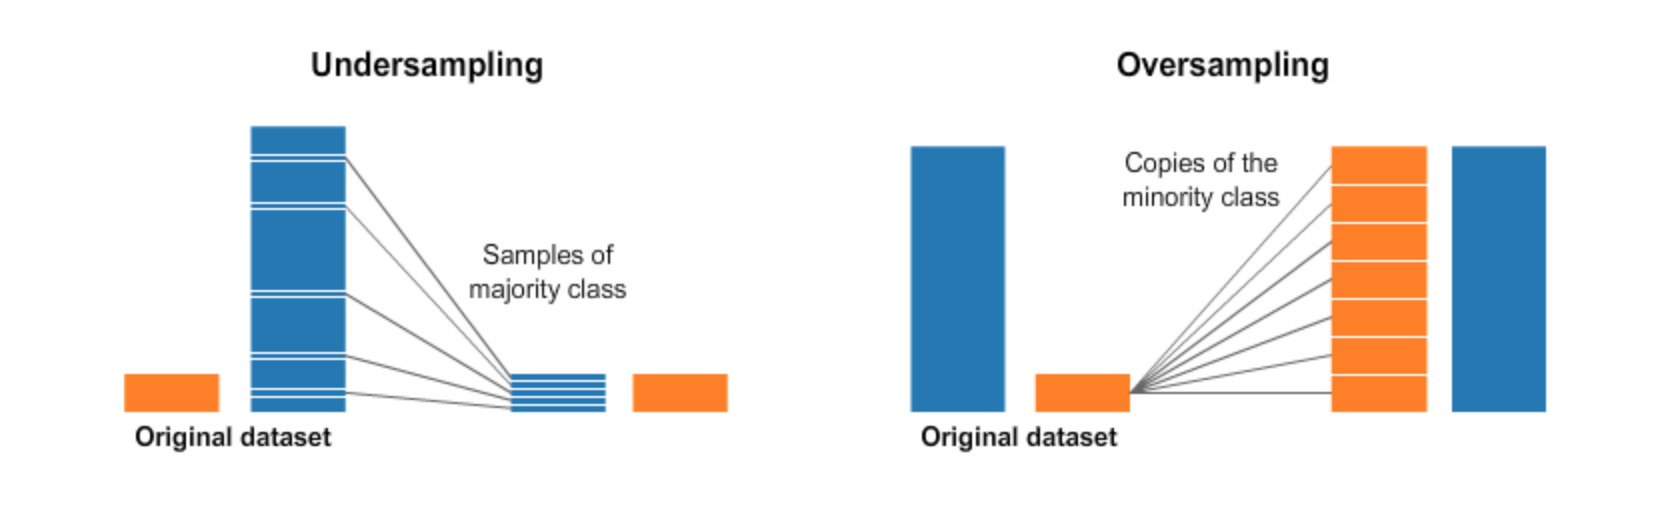

In [11]:
sections_population = df1.groupby('Sector').count()
sections_population

,SiteText,Language
Sector,,
G,5164,5164
J,2403,2403
K,1884,1884
M,5524,5524
N,1913,1913


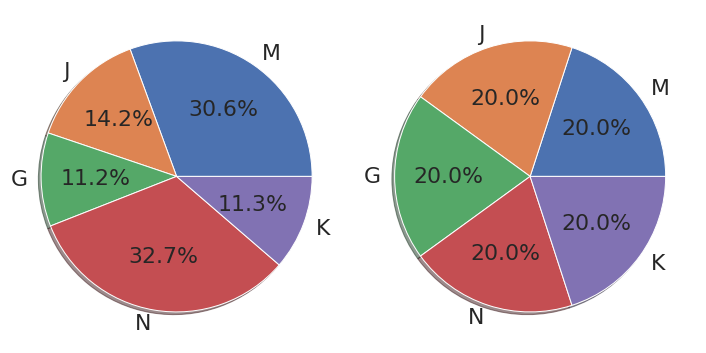

In [12]:
# Below graphs shows the sub-sector categories distribution before and after undersampling of majorities
fig , (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = ((10,10)))
ax1.pie(df1.groupby('Sector').count().agg(pd.Series.tolist)['SiteText'],\
                                           labels = ['M', 'J', 'G', 'N', 'K'], shadow = True ,\
                                            autopct="%.1f%%", textprops={'fontsize': 22})

n_samp = df1.groupby('Sector').count().min()[0]
df1 = pd.concat([df1[df1["Sector"] == 'G'][:n_samp], df1[df1["Sector"] == 'J'][:n_samp],\
                 df1[df1["Sector"] == 'K'][:n_samp], df1[df1["Sector"] == 'M'][:n_samp],\
                                           df1[df1["Sector"] == 'N'][:n_samp]], axis = 0)

ax2.pie(df1.groupby('Sector').count().agg(pd.Series.tolist)['SiteText'],\
                                           labels = ['M', 'J', 'G', 'N', 'K'], shadow = True ,\
                                           autopct="%.1f%%", textprops={'fontsize': 22})

plt.tight_layout()
plt.show()

# GOING THROUGH ONE RECORD AS A SAMPLE 
As I mentioned earlier, exploring the data always honestly will pay off. Hence, as a sample, I would like to analyze one record. The below cell shows the content of the first record's first field. As is shown in the below cell, this ugly guy looks quite messy and during this notebook is my duty to extract useful hidden patterns from this messy file and I will do it.

In [13]:
df1.iloc[0,0]

' Buiten koken op houtvuur is een hele belevenis met de Buitenkok Antoin Buiting: 06-55121389 info@buitenkok.com Facebook Twitter Facebook Twitter0 Items Workshops Workshops en bedrijfsuitjes koken Open workshops â\x80\x9cBuiten kokenâ\x80\x9d Recensies Catering BBQ, Catering, borrels, bruiloften, feestjes, bedrijfsuitjes Winter BBQRecepten Verhuur Buitenkookproducten Oklahoma BBQ huren BBQ driepoot huren Contact Selecteer een pagina Workshops Workshops en bedrijfsuitjes koken Open workshops â\x80\x9cBuiten kokenâ\x80\x9d Recensies Catering BBQ, Catering, borrels, bruiloften, feestjes, bedrijfsuitjes Winter BBQRecepten Verhuur Buitenkookproducten Oklahoma BBQ huren BBQ driepoot huren Contact 21 januari | Workshop Buitenkoken met Wild Exclusieve workshop Jaarrond buitenkoken Natuurlijk kan dat! Op zoek naar een stoer uitje?lees meer... Lekker koken op houtvuur en eten in een boomgaard?Doe mee met een workshop en schrijf je in voor een van de workshops Op zoek naar een mooie locatie?Buit

As you may be noticed, it is also not in English and looks mostly Dutch. This might signal that there is no guarantee which you will not have the text from other languages. To if there are texts from the other languages or not, we have to develop a function or class which can extract the type of language by applying it into the text. Such a function is developed and will see in the next cell. Its name is "get_lang" and just by applying it into the first column of the given dataset, it extracts the corresponding language to the given text. The type of language will be the first feature created in this journey and will be useful. 

In [14]:
# For use in the future, the language in which the corresponding document is written is
# extracted under the name "Language". Since we see only top 10 records, we only see one record for English
# How ever they might be more and in the following, we specifically will count a number of them. 
df1['Language'] = df1['SiteText'].apply(get_lang)
df1.head(10)

,SiteText,Sector,Language
9474,Buiten koken op houtvuur is een hele beleveni...,G,nl
5065,emmlight | Light is our Nature emmlight Englis...,G,nl
6498,Auto accessoires en tuning onderdelen online ...,G,nl
11825,QIPTV â Experiencing the future of Televisio...,G,en
15672,Â - Home Â Â Â Â Home Home Over ons Producten...,G,nl
6713,Het Torenkamertje - Puur ouderschap - Het Tore...,G,nl
3074,Mijnheer Truck Banden | Groothandel in vrachtw...,G,nl
15733,Business Software Haaglanden Boekhouden met Ac...,G,nl
12728,"Musthaves | Original gifts, interior accessor...",G,en
4282,Home - Giraffe Coffee Roasters Â­ I'm looking ...,G,nl


<p style='teData_lgdt-align: justify;'>As we see from the above cell, the texts will mostly be in dutch. But what about the other guys, do we see them frequently or not. To answer this question by using the group by the method the contribution of the languages which are already in the selected dataset is written as dataframe. As is clear, the two dominant languages are Dutch than English, respectively. The presence of other languages is very rare. Hence we can follow two strategies. First, accept them as an outlier and easily drop them because they effectively will affect the results of the model. Second, can keep these poor guys to give them an opportunity to contribute to the model. Then the natural question would be if they will not affect the accuracy of the model? The almost precise answer would be no because we are able to translate them into dutch as well (however google translate which I will use is not working perfectly but still is very appreciated). So I would like to keep them (they are in total less than one percent of the total population). </>

In [15]:
df1.groupby('Language').count()

,SiteText,Sector
Language,,
af,2,2
ca,5,5
cs,1,1
da,3,3
de,23,23
en,1573,1573
es,3,3
fr,4,4
nl,7788,7788


In [16]:
def translate_column(text, target_language):
    """ This function accepts a given text and translate it into the target language specified by user.
    Input type    : String
    Output type   : String
    Usage example : Below cell. 
    """
    return translator.translate(text, lang_tgt = target_language)

## WHY I DECIDED TO GO AHEAD WITH DUTCH RATHER THAN ENGLISH
One may raise a question why I decided to go ahead with Dutch rather than English which perhaps would be easier for me. Basically, the answer is quite simple. Because the majority of the texts are in Dutch and by translating those from English to Dutch I will do fewer errors than translating the dutch to English. Furthermore, the results which we are looking for do not depend on it. I decided to continue with Dutch. 

In [17]:
translator         = google_translator()

df2 = df1[df1['Language'] == 'nl']

df2['SiteText_Nl'] = df2['SiteText']

df3 = df1[df1['Language'] != 'nl']

df3['SiteText_Nl'] = df3['SiteText'].apply(lambda x: translate_column(x, 'nl'))

In [18]:
df1 = pd.concat([df2, df3], axis = 0)
df1.head()

,SiteText,Sector,Language,SiteText_Nl
9474,Buiten koken op houtvuur is een hele beleveni...,G,nl,Buiten koken op houtvuur is een hele beleveni...
5065,emmlight | Light is our Nature emmlight Englis...,G,nl,emmlight | Light is our Nature emmlight Englis...
6498,Auto accessoires en tuning onderdelen online ...,G,nl,Auto accessoires en tuning onderdelen online ...
15672,Â - Home Â Â Â Â Home Home Over ons Producten...,G,nl,Â - Home Â Â Â Â Home Home Over ons Producten...
6713,Het Torenkamertje - Puur ouderschap - Het Tore...,G,nl,Het Torenkamertje - Puur ouderschap - Het Tore...


So, since we are all set, let's start cleaning the text to be able to extract hidden information which is not clear at first sight into crude data. In what follows, we will try to use self-developed codes (a few of them are just borrowed from the internet and I am just using them). Most of those self-developed functions are living below cell and I will try to use them in the following text cleaning process.


I have to mention that, it would be more proficient to place these functions in another file as a library and call them whenever need them. However, as we discussed, I have to present this project as a second interview and to this end, I kept them here in the main notebook to be in front of me and hope they will help me to use them and explain this project more precisely and easily, accordingly.

In [19]:
# function to convert numbers to words
def num_to_words(text):
    """
    Return :- text which have all numbers or integers in the form of words
    Input  :- string
    Output :- string
    """
    # splitting text into words with space
    after_spliting = text.split()
    for index in range(len(after_spliting)):
        if after_spliting[index].isdigit():
            after_spliting[index] = num2words(after_spliting[index])

    # joining list into string with space
    numbers_to_words = ' '.join(after_spliting)
    return numbers_to_words

def accented_ASCII(text):
    """
    Return :- text after converting accented characters
    Input  :- string
    Output :- string
    """
    # apply unidecode function on text to convert
    # accented characters to ASCII values
    text = unidecode.unidecode(text)
    return text

def freq_words(text):
    """
    Return :- Most frequent words
    Input  :- string
    Output :-
    """
    # tokenization
    tokens = word_tokenize(text)
    for word in tokens:
        counter[word]= +1
    FrequentWords = []
    # take top 10 frequent words
    for (word, word_count) in counter.most_common(10):
        FrequentWords.append(word)
    return FrequentWords

def remove_fw(text, FrequentWords):
    """
    Return :- String after removing frequent words
    Input  :- String
    Output :- String
    """
    tokens = word_tokenize(text)
    without_fw = []
    for word in tokens:
        if word not in FrequentWords:
            without_fw.append(word) 
    without_fw = ' '.join(without_fw)
    return without_fw


def rare_words(text):
    """
    This function finds the most rare words of a given text.
    Input  :- string
    Output :- list of rare words
    """
    # tokenization
    tokens = word_tokenize(text)
    for word in tokens:
        counter[word]= +1
    RareWords = []
    number_rare_words = 10
    # take top 10 frequent words
    frequentWords = counter.most_common()
    for (word, word_count) in frequentWords[:-number_rare_words:-1]:
        RareWords.append(word)
    return RareWords

def remove_rw(text, RareWords):
    """
    This function removes the most rare words froma given text. Since the most rare words do not play 
    profound role in our analysis, it makes more scence to drop them.
    Input  :- String
    Output :- String
    """
    tokens = word_tokenize(text)
    without_rw = []
    for word in tokens:
        if word not in RareWords:
            without_rw.append(word)

    without_rw = ' '.join(without_fw)
    return without_rw


def remove_single_char(text):
    """
    This function designed to remove single characters from a given text.
    Input  :- string
    Output :- string
    """
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
    return without_sc


def html_remover(data):
    """ This function removes the charachters related to the HTML nature of the text.
    Input  :- string
    Output :- string
    """
    beauti = BeautifulSoup(data,'html.parser')
    return beauti.get_text()


# to remove URL
def url_remover(data):
    """ This function removes the URL from the text.
    Input  :- string
    Output :- string
    
    """
    return re.sub(r'https\S','',data)



def num_remover(data):
    """ This function is designed to removes the nmbers from a given text.
    Input  :- string
    Output :- string
    
    """
    return re.sub(r'\d+', '',data)

def remove_round_brackets(data):
    """ This function is designed to removes the rounded brackets from a given text.
    Input  :- string
    Output :- string
    
    """
    return re.sub('\(.*?\)','',data)

def remove_punc(data):
    """ This function is designed to removes the potential puntucations from a given text.
    Input  :- string
    Output :- string
    
    """    
    trans = str.maketrans('','', string.punctuation)
    return data.translate(trans)

def white_space(data):
    """ This function is designed to removes the white spaces from a given text.
    Input  :- string
    Output :- string
    
    """
    return ' '.join(data.split())


def web_associated(data):
    """ This function is a gathering of some of above mentioned fuctions which by calling this function, you
    will be able to appy bounch of them in a single shot. As is clear, those functions which are designed to
    deal with web-related things are gathered here.
    Input  :- string
    Output :- string
    
    """    
    text = html_remover(data)
    text = url_remover(text)
    text = num_remover(text)
    text = remove_round_brackets(text)
    text = remove_round_brackets(text)
    text = remove_punc(text)
    text = white_space(text)
    return text


def complete_noise(data):
    """ This function is designed to remove some potential noises (e.g., rounded bracket). Similarly,
    it is also combination of some simple functions.
    Input  :- string
    Output :- string
    
    """    
    new_data = remove_round_brackets(data)
    new_data = remove_punc(new_data)
    new_data = white_space(new_data)
    return new_data

def clean_text(text):#will replace the html characters with " "
    """ This function also does some cleaning for a given text file. It does some simple tasks such as
    lowering cases and  ....
    Input  :- string
    Output :- string
    
    """       
    text=re.sub('<.*?>', ' ', text)  
    #To remove the punctuations
    text = text.translate(str.maketrans(' ',' ',string.punctuation))
    #will consider only alphabets and numerics
    text = re.sub('[^a-zA-Z]',' ',text)  
    #will replace newline with space
    text = re.sub("\n"," ",text)
    #will convert to lower case
    text = text.lower()
    # will split and join the words
    text=' '.join(text.split())
    return text#Running the Funtion


def tokenize(text):
    """ This function is designed to tokenize a given long string into simple parts (e.g., words).
    lowering cases and  ....
    Input  :- string
    Output :- string
    
    """     
    text = re.split('\s+' ,text)
    return [x.lower() for x in text]


# Remove tokens of length less than 3
def remove_small_words(text):
    """ This function is designed to drop those words which they have length less than 3. Most of the time
    those words which have length less than 3 are articles. For example, "The" which by itself does not bring 
    any meaning to the text so it makes more scence to drop them.
    Input  :- string
    Output :- string
    
    """     
    return [x for x in text if len(x) > 3 ]

# Create sentences to get clean text as input for vectors

def return_sentences(tokens):
    """ This function is designed to regroup the toknized words to make a sentences.
    Input  :- string
    Output :- string
    
    """     
    a = [word for word in tokens]
    return " ".join(a)

def stopword(string):
    """ This function is designed to drop stop words from a given text.
    Input  :- string
    Output :- string
    """     
    a = [i for i in string.split() if i not in stopwords.words('dutch')]
    return ' '.join(a)

def stemming(string):
    """ This function is designed to stemize the words.
    Input  :- string
    Output :- string
    
    """     
    a = [snow.stem(i) for i in word_tokenize(string) ]
    return " ".join(a)

## TEXT CLEANING
As a starting point for the cleaning of a given text. First, we will remove potential punctuations from the text. We will move on by creating new features gradually by cleaning the whole text. Generally, these newly created features can be very useful. For example, as you will see in a few next cells, after cleaning a given dataset and removing some rare and irrelevant words we will tokenize the rest of them. This tokenized text can help us to estimate the main topic of the text. In our case study database, it means for a given text from customers' websites which is obtained by web scrapping, we can extract their field of work, products or maybe about their needs then company can make a data-driven decision and manage their opportunity. If I will have enough time I will do this part as well and will explain the technical details as well.


## NOTE
As I mentioned earlier, it would be more efficient and proficient to collect the procedure of text cleaning as a class with some methods. But, since I have to present my code as an interview, for the sake of simplicity and avoiding any confusion I decided not to go into complications and keep them easy to track during the interview. However, if I will be selected to present my code, I will bring both versions (hardcoded and classified versions).

In [20]:
# Remove all punctuations from the text
import string as st
def remove_punct(text):
    return ("".join([ch for ch in text if ch not in st.punctuation]))

df1['remove_punct']       = df1['SiteText_Nl'   ].apply(lambda x: remove_punct(x),     )
df1.head()

,SiteText,Sector,Language,SiteText_Nl,remove_punct
9474,Buiten koken op houtvuur is een hele beleveni...,G,nl,Buiten koken op houtvuur is een hele beleveni...,Buiten koken op houtvuur is een hele beleveni...
5065,emmlight | Light is our Nature emmlight Englis...,G,nl,emmlight | Light is our Nature emmlight Englis...,emmlight Light is our Nature emmlight English...
6498,Auto accessoires en tuning onderdelen online ...,G,nl,Auto accessoires en tuning onderdelen online ...,Auto accessoires en tuning onderdelen online ...
15672,Â - Home Â Â Â Â Home Home Over ons Producten...,G,nl,Â - Home Â Â Â Â Home Home Over ons Producten...,Â Home Â Â Â Â Home Home Over ons Producten ...
6713,Het Torenkamertje - Puur ouderschap - Het Tore...,G,nl,Het Torenkamertje - Puur ouderschap - Het Tore...,Het Torenkamertje Puur ouderschap Het Torenk...


In [21]:
# The below cell will produce two new features under the names "web_associated" and "complete_noise"
# attached to the original data-frame.

In [22]:
df1['web_associated']     = df1['remove_punct'  ].apply(lambda x: web_associated(x),   )
df1['complete_noise']     = df1['web_associated'].apply(lambda x: complete_noise(x),   )
df1.head()

,SiteText,Sector,Language,SiteText_Nl,remove_punct,web_associated,complete_noise
9474,Buiten koken op houtvuur is een hele beleveni...,G,nl,Buiten koken op houtvuur is een hele beleveni...,Buiten koken op houtvuur is een hele beleveni...,Buiten koken op houtvuur is een hele belevenis...,Buiten koken op houtvuur is een hele belevenis...
5065,emmlight | Light is our Nature emmlight Englis...,G,nl,emmlight | Light is our Nature emmlight Englis...,emmlight Light is our Nature emmlight English...,emmlight Light is our Nature emmlight English ...,emmlight Light is our Nature emmlight English ...
6498,Auto accessoires en tuning onderdelen online ...,G,nl,Auto accessoires en tuning onderdelen online ...,Auto accessoires en tuning onderdelen online ...,Auto accessoires en tuning onderdelen online k...,Auto accessoires en tuning onderdelen online k...
15672,Â - Home Â Â Â Â Home Home Over ons Producten...,G,nl,Â - Home Â Â Â Â Home Home Over ons Producten...,Â Home Â Â Â Â Home Home Over ons Producten ...,Â Home Â Â Â Â Home Home Over ons Producten Wo...,Â Home Â Â Â Â Home Home Over ons Producten Wo...
6713,Het Torenkamertje - Puur ouderschap - Het Tore...,G,nl,Het Torenkamertje - Puur ouderschap - Het Tore...,Het Torenkamertje Puur ouderschap Het Torenk...,Het Torenkamertje Puur ouderschap Het Torenkam...,Het Torenkamertje Puur ouderschap Het Torenkam...


In [23]:
# The below cell will produce one new features under the names "stopword".

In [24]:
df1['stopword']           = df1['complete_noise'    ].apply(lambda x: stopword(str(x)) )
df1.head()

,SiteText,Sector,Language,SiteText_Nl,remove_punct,web_associated,complete_noise,stopword
9474,Buiten koken op houtvuur is een hele beleveni...,G,nl,Buiten koken op houtvuur is een hele beleveni...,Buiten koken op houtvuur is een hele beleveni...,Buiten koken op houtvuur is een hele belevenis...,Buiten koken op houtvuur is een hele belevenis...,Buiten koken houtvuur hele belevenis Buitenkok...
5065,emmlight | Light is our Nature emmlight Englis...,G,nl,emmlight | Light is our Nature emmlight Englis...,emmlight Light is our Nature emmlight English...,emmlight Light is our Nature emmlight English ...,emmlight Light is our Nature emmlight English ...,emmlight Light our Nature emmlight English Ned...
6498,Auto accessoires en tuning onderdelen online ...,G,nl,Auto accessoires en tuning onderdelen online ...,Auto accessoires en tuning onderdelen online ...,Auto accessoires en tuning onderdelen online k...,Auto accessoires en tuning onderdelen online k...,Auto accessoires tuning onderdelen online kope...
15672,Â - Home Â Â Â Â Home Home Over ons Producten...,G,nl,Â - Home Â Â Â Â Home Home Over ons Producten...,Â Home Â Â Â Â Home Home Over ons Producten ...,Â Home Â Â Â Â Home Home Over ons Producten Wo...,Â Home Â Â Â Â Home Home Over ons Producten Wo...,Â Home Â Â Â Â Home Home Over Producten Worksh...
6713,Het Torenkamertje - Puur ouderschap - Het Tore...,G,nl,Het Torenkamertje - Puur ouderschap - Het Tore...,Het Torenkamertje Puur ouderschap Het Torenk...,Het Torenkamertje Puur ouderschap Het Torenkam...,Het Torenkamertje Puur ouderschap Het Torenkam...,Het Torenkamertje Puur ouderschap Het Torenkam...


In [25]:
# One of the most important parts of the text cleaning is tokenizing the text which can doa lot of useful
# transformation on a given text, accordingly. The below cell indicates the function which will do the 
# mentioned job by applying it into a column of our dataset.

In [26]:
import re
def tokenize(text):
    """ This function is designed to tokenize a given text file which accepts it as string and in return
    gives back the list of strings.
    Input  :- string
    Output :- string
    
    """
    text = re.split('\s+' ,text)
    return [x.lower() for x in text]

In [27]:
df1['tokens'] = df1['stopword'].apply(lambda x : tokenize(x))
df1.head()

,SiteText,Sector,Language,SiteText_Nl,remove_punct,web_associated,complete_noise,stopword,tokens
9474,Buiten koken op houtvuur is een hele beleveni...,G,nl,Buiten koken op houtvuur is een hele beleveni...,Buiten koken op houtvuur is een hele beleveni...,Buiten koken op houtvuur is een hele belevenis...,Buiten koken op houtvuur is een hele belevenis...,Buiten koken houtvuur hele belevenis Buitenkok...,"[buiten, koken, houtvuur, hele, belevenis, bui..."
5065,emmlight | Light is our Nature emmlight Englis...,G,nl,emmlight | Light is our Nature emmlight Englis...,emmlight Light is our Nature emmlight English...,emmlight Light is our Nature emmlight English ...,emmlight Light is our Nature emmlight English ...,emmlight Light our Nature emmlight English Ned...,"[emmlight, light, our, nature, emmlight, engli..."
6498,Auto accessoires en tuning onderdelen online ...,G,nl,Auto accessoires en tuning onderdelen online ...,Auto accessoires en tuning onderdelen online ...,Auto accessoires en tuning onderdelen online k...,Auto accessoires en tuning onderdelen online k...,Auto accessoires tuning onderdelen online kope...,"[auto, accessoires, tuning, onderdelen, online..."
15672,Â - Home Â Â Â Â Home Home Over ons Producten...,G,nl,Â - Home Â Â Â Â Home Home Over ons Producten...,Â Home Â Â Â Â Home Home Over ons Producten ...,Â Home Â Â Â Â Home Home Over ons Producten Wo...,Â Home Â Â Â Â Home Home Over ons Producten Wo...,Â Home Â Â Â Â Home Home Over Producten Worksh...,"[â, home, â, â, â, â, home, home, over, produc..."
6713,Het Torenkamertje - Puur ouderschap - Het Tore...,G,nl,Het Torenkamertje - Puur ouderschap - Het Tore...,Het Torenkamertje Puur ouderschap Het Torenk...,Het Torenkamertje Puur ouderschap Het Torenkam...,Het Torenkamertje Puur ouderschap Het Torenkam...,Het Torenkamertje Puur ouderschap Het Torenkam...,"[het, torenkamertje, puur, ouderschap, het, to..."


In [28]:
# Remove tokens of length less than 3
def remove_small_words(text):
    return [x for x in text if len(x) > 3 ]

In [29]:
df1['larger_tokens'] = df1['tokens'].apply(lambda x : remove_small_words(x))
df1.head()

,SiteText,Sector,Language,SiteText_Nl,remove_punct,web_associated,complete_noise,stopword,tokens,larger_tokens
9474,Buiten koken op houtvuur is een hele beleveni...,G,nl,Buiten koken op houtvuur is een hele beleveni...,Buiten koken op houtvuur is een hele beleveni...,Buiten koken op houtvuur is een hele belevenis...,Buiten koken op houtvuur is een hele belevenis...,Buiten koken houtvuur hele belevenis Buitenkok...,"[buiten, koken, houtvuur, hele, belevenis, bui...","[buiten, koken, houtvuur, hele, belevenis, bui..."
5065,emmlight | Light is our Nature emmlight Englis...,G,nl,emmlight | Light is our Nature emmlight Englis...,emmlight Light is our Nature emmlight English...,emmlight Light is our Nature emmlight English ...,emmlight Light is our Nature emmlight English ...,emmlight Light our Nature emmlight English Ned...,"[emmlight, light, our, nature, emmlight, engli...","[emmlight, light, nature, emmlight, english, n..."
6498,Auto accessoires en tuning onderdelen online ...,G,nl,Auto accessoires en tuning onderdelen online ...,Auto accessoires en tuning onderdelen online ...,Auto accessoires en tuning onderdelen online k...,Auto accessoires en tuning onderdelen online k...,Auto accessoires tuning onderdelen online kope...,"[auto, accessoires, tuning, onderdelen, online...","[auto, accessoires, tuning, onderdelen, online..."
15672,Â - Home Â Â Â Â Home Home Over ons Producten...,G,nl,Â - Home Â Â Â Â Home Home Over ons Producten...,Â Home Â Â Â Â Home Home Over ons Producten ...,Â Home Â Â Â Â Home Home Over ons Producten Wo...,Â Home Â Â Â Â Home Home Over ons Producten Wo...,Â Home Â Â Â Â Home Home Over Producten Worksh...,"[â, home, â, â, â, â, home, home, over, produc...","[home, home, home, over, producten, workshops,..."
6713,Het Torenkamertje - Puur ouderschap - Het Tore...,G,nl,Het Torenkamertje - Puur ouderschap - Het Tore...,Het Torenkamertje Puur ouderschap Het Torenk...,Het Torenkamertje Puur ouderschap Het Torenkam...,Het Torenkamertje Puur ouderschap Het Torenkam...,Het Torenkamertje Puur ouderschap Het Torenkam...,"[het, torenkamertje, puur, ouderschap, het, to...","[torenkamertje, puur, ouderschap, torenkamertj..."


In [30]:
''' Remove stopwords. Here, NLTK corpus list is used for a match. However, a customized user-defined 
    list could be created and used to limit the matches in input text. 
'''
def remove_stopwords(text):
    return [word for word in text if word not in nltk.corpus.stopwords.words('dutch')]

In [31]:
df1['clean_tokens'] = df1['larger_tokens'].apply(lambda x : remove_stopwords(x))
df1.head()

,SiteText,Sector,Language,SiteText_Nl,remove_punct,web_associated,complete_noise,stopword,tokens,larger_tokens,clean_tokens
9474,Buiten koken op houtvuur is een hele beleveni...,G,nl,Buiten koken op houtvuur is een hele beleveni...,Buiten koken op houtvuur is een hele beleveni...,Buiten koken op houtvuur is een hele belevenis...,Buiten koken op houtvuur is een hele belevenis...,Buiten koken houtvuur hele belevenis Buitenkok...,"[buiten, koken, houtvuur, hele, belevenis, bui...","[buiten, koken, houtvuur, hele, belevenis, bui...","[buiten, koken, houtvuur, hele, belevenis, bui..."
5065,emmlight | Light is our Nature emmlight Englis...,G,nl,emmlight | Light is our Nature emmlight Englis...,emmlight Light is our Nature emmlight English...,emmlight Light is our Nature emmlight English ...,emmlight Light is our Nature emmlight English ...,emmlight Light our Nature emmlight English Ned...,"[emmlight, light, our, nature, emmlight, engli...","[emmlight, light, nature, emmlight, english, n...","[emmlight, light, nature, emmlight, english, n..."
6498,Auto accessoires en tuning onderdelen online ...,G,nl,Auto accessoires en tuning onderdelen online ...,Auto accessoires en tuning onderdelen online ...,Auto accessoires en tuning onderdelen online k...,Auto accessoires en tuning onderdelen online k...,Auto accessoires tuning onderdelen online kope...,"[auto, accessoires, tuning, onderdelen, online...","[auto, accessoires, tuning, onderdelen, online...","[auto, accessoires, tuning, onderdelen, online..."
15672,Â - Home Â Â Â Â Home Home Over ons Producten...,G,nl,Â - Home Â Â Â Â Home Home Over ons Producten...,Â Home Â Â Â Â Home Home Over ons Producten ...,Â Home Â Â Â Â Home Home Over ons Producten Wo...,Â Home Â Â Â Â Home Home Over ons Producten Wo...,Â Home Â Â Â Â Home Home Over Producten Worksh...,"[â, home, â, â, â, â, home, home, over, produc...","[home, home, home, over, producten, workshops,...","[home, home, home, producten, workshops, openi..."
6713,Het Torenkamertje - Puur ouderschap - Het Tore...,G,nl,Het Torenkamertje - Puur ouderschap - Het Tore...,Het Torenkamertje Puur ouderschap Het Torenk...,Het Torenkamertje Puur ouderschap Het Torenkam...,Het Torenkamertje Puur ouderschap Het Torenkam...,Het Torenkamertje Puur ouderschap Het Torenkam...,"[het, torenkamertje, puur, ouderschap, het, to...","[torenkamertje, puur, ouderschap, torenkamertj...","[torenkamertje, puur, ouderschap, torenkamertj..."


In [32]:
from nltk import PorterStemmer, WordNetLemmatizer
# Apply stemming to get root words 
def stemming(text):
    ps = PorterStemmer()
    return [ps.stem(word) for word in text]

In [33]:
df1['stem_words'] = df1['clean_tokens'].apply(lambda wrd: stemming(wrd))
df1.head()

,SiteText,Sector,Language,SiteText_Nl,remove_punct,web_associated,complete_noise,stopword,tokens,larger_tokens,clean_tokens,stem_words
9474,Buiten koken op houtvuur is een hele beleveni...,G,nl,Buiten koken op houtvuur is een hele beleveni...,Buiten koken op houtvuur is een hele beleveni...,Buiten koken op houtvuur is een hele belevenis...,Buiten koken op houtvuur is een hele belevenis...,Buiten koken houtvuur hele belevenis Buitenkok...,"[buiten, koken, houtvuur, hele, belevenis, bui...","[buiten, koken, houtvuur, hele, belevenis, bui...","[buiten, koken, houtvuur, hele, belevenis, bui...","[buiten, koken, houtvuur, hele, beleveni, buit..."
5065,emmlight | Light is our Nature emmlight Englis...,G,nl,emmlight | Light is our Nature emmlight Englis...,emmlight Light is our Nature emmlight English...,emmlight Light is our Nature emmlight English ...,emmlight Light is our Nature emmlight English ...,emmlight Light our Nature emmlight English Ned...,"[emmlight, light, our, nature, emmlight, engli...","[emmlight, light, nature, emmlight, english, n...","[emmlight, light, nature, emmlight, english, n...","[emmlight, light, natur, emmlight, english, ne..."
6498,Auto accessoires en tuning onderdelen online ...,G,nl,Auto accessoires en tuning onderdelen online ...,Auto accessoires en tuning onderdelen online ...,Auto accessoires en tuning onderdelen online k...,Auto accessoires en tuning onderdelen online k...,Auto accessoires tuning onderdelen online kope...,"[auto, accessoires, tuning, onderdelen, online...","[auto, accessoires, tuning, onderdelen, online...","[auto, accessoires, tuning, onderdelen, online...","[auto, accessoir, tune, onderdelen, onlin, kop..."
15672,Â - Home Â Â Â Â Home Home Over ons Producten...,G,nl,Â - Home Â Â Â Â Home Home Over ons Producten...,Â Home Â Â Â Â Home Home Over ons Producten ...,Â Home Â Â Â Â Home Home Over ons Producten Wo...,Â Home Â Â Â Â Home Home Over ons Producten Wo...,Â Home Â Â Â Â Home Home Over Producten Worksh...,"[â, home, â, â, â, â, home, home, over, produc...","[home, home, home, over, producten, workshops,...","[home, home, home, producten, workshops, openi...","[home, home, home, producten, workshop, openin..."
6713,Het Torenkamertje - Puur ouderschap - Het Tore...,G,nl,Het Torenkamertje - Puur ouderschap - Het Tore...,Het Torenkamertje Puur ouderschap Het Torenk...,Het Torenkamertje Puur ouderschap Het Torenkam...,Het Torenkamertje Puur ouderschap Het Torenkam...,Het Torenkamertje Puur ouderschap Het Torenkam...,"[het, torenkamertje, puur, ouderschap, het, to...","[torenkamertje, puur, ouderschap, torenkamertj...","[torenkamertje, puur, ouderschap, torenkamertj...","[torenkamertj, puur, ouderschap, torenkamertj,..."


In [34]:
# Apply lemmatization on tokens
def lemmatize(text):
    word_net = WordNetLemmatizer()
    return [word_net.lemmatize(word) for word in text]

In [35]:
df1['lemma_words'] = df1['clean_tokens'].apply(lambda x : lemmatize(x))
df1.head()

,SiteText,Sector,Language,SiteText_Nl,remove_punct,web_associated,complete_noise,stopword,tokens,larger_tokens,clean_tokens,stem_words,lemma_words
9474,Buiten koken op houtvuur is een hele beleveni...,G,nl,Buiten koken op houtvuur is een hele beleveni...,Buiten koken op houtvuur is een hele beleveni...,Buiten koken op houtvuur is een hele belevenis...,Buiten koken op houtvuur is een hele belevenis...,Buiten koken houtvuur hele belevenis Buitenkok...,"[buiten, koken, houtvuur, hele, belevenis, bui...","[buiten, koken, houtvuur, hele, belevenis, bui...","[buiten, koken, houtvuur, hele, belevenis, bui...","[buiten, koken, houtvuur, hele, beleveni, buit...","[buiten, koken, houtvuur, hele, belevenis, bui..."
5065,emmlight | Light is our Nature emmlight Englis...,G,nl,emmlight | Light is our Nature emmlight Englis...,emmlight Light is our Nature emmlight English...,emmlight Light is our Nature emmlight English ...,emmlight Light is our Nature emmlight English ...,emmlight Light our Nature emmlight English Ned...,"[emmlight, light, our, nature, emmlight, engli...","[emmlight, light, nature, emmlight, english, n...","[emmlight, light, nature, emmlight, english, n...","[emmlight, light, natur, emmlight, english, ne...","[emmlight, light, nature, emmlight, english, n..."
6498,Auto accessoires en tuning onderdelen online ...,G,nl,Auto accessoires en tuning onderdelen online ...,Auto accessoires en tuning onderdelen online ...,Auto accessoires en tuning onderdelen online k...,Auto accessoires en tuning onderdelen online k...,Auto accessoires tuning onderdelen online kope...,"[auto, accessoires, tuning, onderdelen, online...","[auto, accessoires, tuning, onderdelen, online...","[auto, accessoires, tuning, onderdelen, online...","[auto, accessoir, tune, onderdelen, onlin, kop...","[auto, accessoires, tuning, onderdelen, online..."
15672,Â - Home Â Â Â Â Home Home Over ons Producten...,G,nl,Â - Home Â Â Â Â Home Home Over ons Producten...,Â Home Â Â Â Â Home Home Over ons Producten ...,Â Home Â Â Â Â Home Home Over ons Producten Wo...,Â Home Â Â Â Â Home Home Over ons Producten Wo...,Â Home Â Â Â Â Home Home Over Producten Worksh...,"[â, home, â, â, â, â, home, home, over, produc...","[home, home, home, over, producten, workshops,...","[home, home, home, producten, workshops, openi...","[home, home, home, producten, workshop, openin...","[home, home, home, producten, workshop, openin..."
6713,Het Torenkamertje - Puur ouderschap - Het Tore...,G,nl,Het Torenkamertje - Puur ouderschap - Het Tore...,Het Torenkamertje Puur ouderschap Het Torenk...,Het Torenkamertje Puur ouderschap Het Torenkam...,Het Torenkamertje Puur ouderschap Het Torenkam...,Het Torenkamertje Puur ouderschap Het Torenkam...,"[het, torenkamertje, puur, ouderschap, het, to...","[torenkamertje, puur, ouderschap, torenkamertj...","[torenkamertje, puur, ouderschap, torenkamertj...","[torenkamertj, puur, ouderschap, torenkamertj,...","[torenkamertje, puur, ouderschap, torenkamertj..."


In [36]:
# Create sentences to get clean text as input for vectors
def return_sentences(tokens):
    return " ".join([word for word in tokens])

In [37]:
df1['clean_text'] = df1['lemma_words'].apply(lambda x : return_sentences(x))
df1.head()

,SiteText,Sector,Language,SiteText_Nl,remove_punct,web_associated,complete_noise,stopword,tokens,larger_tokens,clean_tokens,stem_words,lemma_words,clean_text
9474,Buiten koken op houtvuur is een hele beleveni...,G,nl,Buiten koken op houtvuur is een hele beleveni...,Buiten koken op houtvuur is een hele beleveni...,Buiten koken op houtvuur is een hele belevenis...,Buiten koken op houtvuur is een hele belevenis...,Buiten koken houtvuur hele belevenis Buitenkok...,"[buiten, koken, houtvuur, hele, belevenis, bui...","[buiten, koken, houtvuur, hele, belevenis, bui...","[buiten, koken, houtvuur, hele, belevenis, bui...","[buiten, koken, houtvuur, hele, beleveni, buit...","[buiten, koken, houtvuur, hele, belevenis, bui...",buiten koken houtvuur hele belevenis buitenkok...
5065,emmlight | Light is our Nature emmlight Englis...,G,nl,emmlight | Light is our Nature emmlight Englis...,emmlight Light is our Nature emmlight English...,emmlight Light is our Nature emmlight English ...,emmlight Light is our Nature emmlight English ...,emmlight Light our Nature emmlight English Ned...,"[emmlight, light, our, nature, emmlight, engli...","[emmlight, light, nature, emmlight, english, n...","[emmlight, light, nature, emmlight, english, n...","[emmlight, light, natur, emmlight, english, ne...","[emmlight, light, nature, emmlight, english, n...",emmlight light nature emmlight english nederla...
6498,Auto accessoires en tuning onderdelen online ...,G,nl,Auto accessoires en tuning onderdelen online ...,Auto accessoires en tuning onderdelen online ...,Auto accessoires en tuning onderdelen online k...,Auto accessoires en tuning onderdelen online k...,Auto accessoires tuning onderdelen online kope...,"[auto, accessoires, tuning, onderdelen, online...","[auto, accessoires, tuning, onderdelen, online...","[auto, accessoires, tuning, onderdelen, online...","[auto, accessoir, tune, onderdelen, onlin, kop...","[auto, accessoires, tuning, onderdelen, online...",auto accessoires tuning onderdelen online kope...
15672,Â - Home Â Â Â Â Home Home Over ons Producten...,G,nl,Â - Home Â Â Â Â Home Home Over ons Producten...,Â Home Â Â Â Â Home Home Over ons Producten ...,Â Home Â Â Â Â Home Home Over ons Producten Wo...,Â Home Â Â Â Â Home Home Over ons Producten Wo...,Â Home Â Â Â Â Home Home Over Producten Worksh...,"[â, home, â, â, â, â, home, home, over, produc...","[home, home, home, over, producten, workshops,...","[home, home, home, producten, workshops, openi...","[home, home, home, producten, workshop, openin...","[home, home, home, producten, workshop, openin...",home home home producten workshop openingstijd...
6713,Het Torenkamertje - Puur ouderschap - Het Tore...,G,nl,Het Torenkamertje - Puur ouderschap - Het Tore...,Het Torenkamertje Puur ouderschap Het Torenk...,Het Torenkamertje Puur ouderschap Het Torenkam...,Het Torenkamertje Puur ouderschap Het Torenkam...,Het Torenkamertje Puur ouderschap Het Torenkam...,"[het, torenkamertje, puur, ouderschap, het, to...","[torenkamertje, puur, ouderschap, torenkamertj...","[torenkamertje, puur, ouderschap, torenkamertj...","[torenkamertj, puur, ouderschap, torenkamertj,...","[torenkamertje, puur, ouderschap, torenkamertj...",torenkamertje puur ouderschap torenkamertje â­...


In [38]:
# In order to the effect of the text cleaning, I just made some word cloud for the some selected records.
# The obtained word clouds are represented in the below cell.

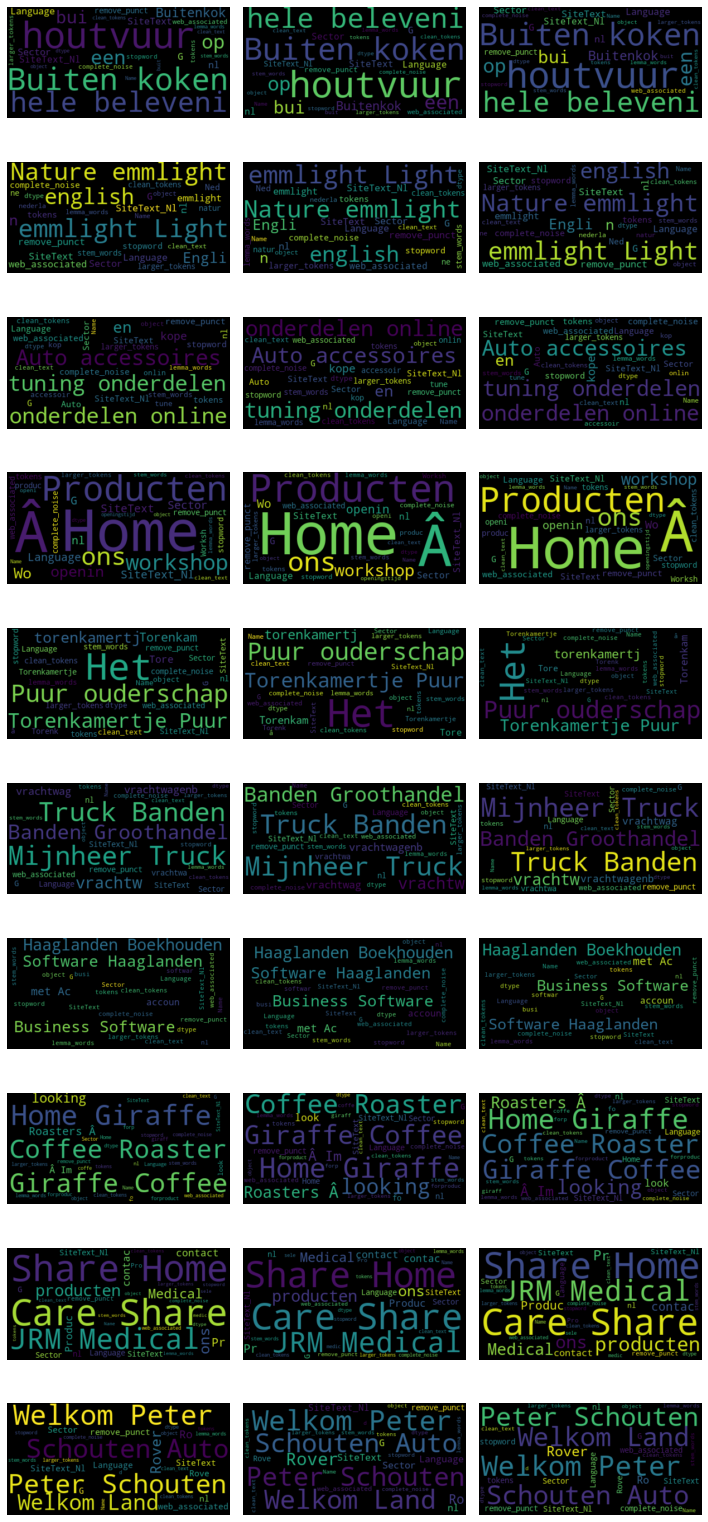

In [39]:
fig, ax = plt.subplots(ncols = 3, nrows = 10, figsize=((10,22)))
for i in range(10):
    for j in range(3):
    # Create and generate a word cloud image:
         wordcloud = WordCloud().generate(str(df1.iloc[i]))
         ax[i][j].imshow(wordcloud, interpolation='bilinear')
         ax[i][j].axis('off')
plt.tight_layout()        
plt.show()   

In [40]:
from sklearn.preprocessing import LabelEncoder

In [41]:
labelencoder = LabelEncoder()

In [42]:
df1['Sector_no'] = labelencoder.fit_transform(df1['Sector'])
df1

,SiteText,Sector,Language,SiteText_Nl,remove_punct,web_associated,complete_noise,stopword,tokens,larger_tokens,clean_tokens,stem_words,lemma_words,clean_text,Sector_no
9474,Buiten koken op houtvuur is een hele beleveni...,G,nl,Buiten koken op houtvuur is een hele beleveni...,Buiten koken op houtvuur is een hele beleveni...,Buiten koken op houtvuur is een hele belevenis...,Buiten koken op houtvuur is een hele belevenis...,Buiten koken houtvuur hele belevenis Buitenkok...,"[buiten, koken, houtvuur, hele, belevenis, bui...","[buiten, koken, houtvuur, hele, belevenis, bui...","[buiten, koken, houtvuur, hele, belevenis, bui...","[buiten, koken, houtvuur, hele, beleveni, buit...","[buiten, koken, houtvuur, hele, belevenis, bui...",buiten koken houtvuur hele belevenis buitenkok...,0
5065,emmlight | Light is our Nature emmlight Englis...,G,nl,emmlight | Light is our Nature emmlight Englis...,emmlight Light is our Nature emmlight English...,emmlight Light is our Nature emmlight English ...,emmlight Light is our Nature emmlight English ...,emmlight Light our Nature emmlight English Ned...,"[emmlight, light, our, nature, emmlight, engli...","[emmlight, light, nature, emmlight, english, n...","[emmlight, light, nature, emmlight, english, n...","[emmlight, light, natur, emmlight, english, ne...","[emmlight, light, nature, emmlight, english, n...",emmlight light nature emmlight english nederla...,0
6498,Auto accessoires en tuning onderdelen online ...,G,nl,Auto accessoires en tuning onderdelen online ...,Auto accessoires en tuning onderdelen online ...,Auto accessoires en tuning onderdelen online k...,Auto accessoires en tuning onderdelen online k...,Auto accessoires tuning onderdelen online kope...,"[auto, accessoires, tuning, onderdelen, online...","[auto, accessoires, tuning, onderdelen, online...","[auto, accessoires, tuning, onderdelen, online...","[auto, accessoir, tune, onderdelen, onlin, kop...","[auto, accessoires, tuning, onderdelen, online...",auto accessoires tuning onderdelen online kope...,0
15672,Â - Home Â Â Â Â Home Home Over ons Producten...,G,nl,Â - Home Â Â Â Â Home Home Over ons Producten...,Â Home Â Â Â Â Home Home Over ons Producten ...,Â Home Â Â Â Â Home Home Over ons Producten Wo...,Â Home Â Â Â Â Home Home Over ons Producten Wo...,Â Home Â Â Â Â Home Home Over Producten Worksh...,"[â, home, â, â, â, â, home, home, over, produc...","[home, home, home, over, producten, workshops,...","[home, home, home, producten, workshops, openi...","[home, home, home, producten, workshop, openin...","[home, home, home, producten, workshop, openin...",home home home producten workshop openingstijd...,0
6713,Het Torenkamertje - Puur ouderschap - Het Tore...,G,nl,Het Torenkamertje - Puur ouderschap - Het Tore...,Het Torenkamertje Puur ouderschap Het Torenk...,Het Torenkamertje Puur ouderschap Het Torenkam...,Het Torenkamertje Puur ouderschap Het Torenkam...,Het Torenkamertje Puur ouderschap Het Torenkam...,"[het, torenkamertje, puur, ouderschap, het, to...","[torenkamertje, puur, ouderschap, torenkamertj...","[torenkamertje, puur, ouderschap, torenkamertj...","[torenkamertj, puur, ouderschap, torenkamertj,...","[torenkamertje, puur, ouderschap, torenkamertj...",torenkamertje puur ouderschap torenkamertje â­...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17249,EXPO-MATE â Your Exhibitions Buddy Â Skip ...,N,en,EXPO-MATE â Uw Exhibitions Buddy Â Ga naar inh...,EXPOMATE â Uw Exhibitions Buddy Â Ga naar inho...,EXPOMATE â Uw Exhibitions Buddy Â Ga naar inho...,EXPOMATE â Uw Exhibitions Buddy Â Ga naar inho...,EXPOMATE â Uw Exhibitions Buddy Â Ga inhoud Ho...,"[expomate, â, uw, exhibitions, buddy, â, ga, i...","[expomate, exhibitions, buddy, inhoud, home, i...","[expomate, exhibitions, buddy, inhoud, home, i...","[expom, exhibit, buddi, inhoud, home, introduc...","[expomate, exhibition, buddy, inhoud, home, in...",expomate exhibition buddy inhoud home introduc...,4
9789,Facebook Jump to Sections of this page Acces

In [43]:
# Split data in to training, testing sets
from sklearn.model_selection import train_test_split
text_train, text_test, y_train, y_test = train_test_split(df1['clean_text'], df1['Sector_no'], test_size = 0.2)

In [44]:
df2 = df1[['clean_text', 'Sector_no']]
df2

,clean_text,Sector_no
9474,buiten koken houtvuur hele belevenis buitenkok...,0
5065,emmlight light nature emmlight english nederla...,0
6498,auto accessoires tuning onderdelen online kope...,0
15672,home home home producten workshop openingstijd...,0
6713,torenkamertje puur ouderschap torenkamertje â­...,0
...,...,...
17249,expomate exhibition buddy inhoud home introduc...,4
9789,facebook secties paginatoegankelijkheid help d...,4
5211,sasso pharma early stage nonclinical breakthro...,4
619,raju security security professional home shop ...,4


In [45]:
# Convert lemmatized words to Tf-Idf feature vectors
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf   = TfidfVectorizer()
X_train = tfidf.fit_transform(text_train)
X_test  = tfidf.transform(text_test)

# MODELLING
To obtain the best prediction, we have to select the best model for our problem. To do this end, based on 
cross-validation technique we will perform the classification with some of the very well-known multiclass classifiers and then will choose the best one to go ahead with it. The next question would be, is still room to improve the accuracy of the selected model? The answer perhaps is yes. Usually, there is room to improve the accuracy of the selected model by means of hyper-parameter tuning. As a next step, e will try to tune the hyper-parameters of the selected model by using the grid-search method. Once the best model with the best parameters is obtained we can deploy our model and investigate its best performance.

## MODEL SELECTION 
The below cell shows the model selection procedure which is done by using the cross-validation technique. The cross-validation method is a part of the scikit-learn library. 

In [46]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

In [47]:
models    = []
models.append(( 'LGR'  , LogisticRegression()))
models.append(( 'KNN'  , KNeighborsClassifier()))
models.append(( 'RFC'  , RandomForestClassifier()))
models.append(( 'CAR'  , DecisionTreeClassifier()))
models.append(( 'SVM'  , SVC()))
# evaluate each model in turn
results   = []
names     = []
scoring   = 'accuracy'
for name, model in models:
    kfold = KFold(n_splits = 10, random_state = None, shuffle = False)
    cv_results = cross_val_score(model, X_train, y_train, cv = kfold, scoring = scoring)
    results.append(cv_results)
    names.append(name)
    print('The obtained mean value for the model {} is {:6.4} and the corresponding std is {:6.4}'.\
                                                  format(name, cv_results.mean(), cv_results.std()))

The obtained mean value for the model LGR is 0.6043 and the corresponding std is 0.01565
The obtained mean value for the model KNN is 0.5117 and the corresponding std is 0.01497
The obtained mean value for the model RFC is 0.5604 and the corresponding std is 0.0143
The obtained mean value for the model CAR is 0.4152 and the corresponding std is 0.02472
The obtained mean value for the model SVM is 0.5943 and the corresponding std is 0.0172


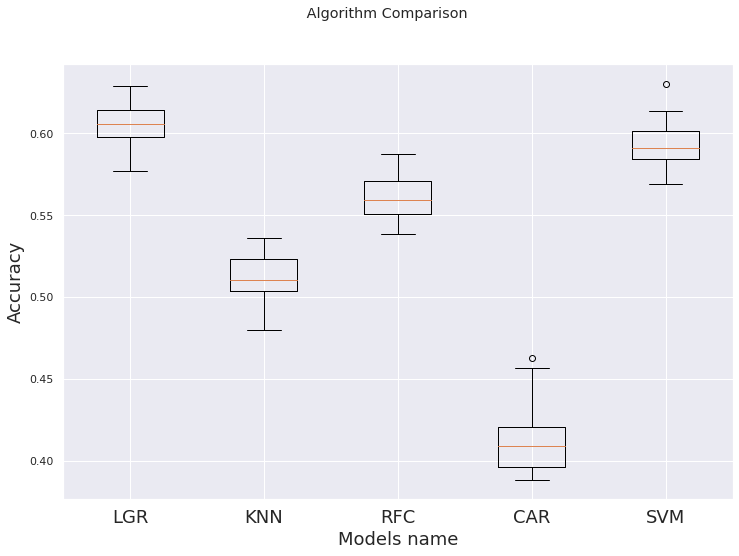

In [48]:
from matplotlib import pyplot
fig = pyplot.figure( figsize = ((12,8)))
ax  = fig.add_subplot(1, 1, 1)
pyplot.boxplot(results)
ax.set_xticklabels(names)
ax.set_xlabel('Models name', fontsize = 18)
ax.set_ylabel('Accuracy', fontsize = 18,)
ax.set_xticklabels(['LGR', 'KNN', 'RFC', 'CAR', 'SVM'], fontsize = 18)
fig.suptitle( ' Algorithm Comparison ' )
pyplot.show()

## MODEL HYPER-PARAMETER TUNNING
As I mentioned earlier, after selecting the best model still there is room to improve the accuracy of the model.
Hyper-parameters of the machine learning models provide a knob to tune their performance. In the below cell I will
use this advantage to improve the performance of the "$\textit{LogisticRegressor}$" which is selected from the previous step as the
best performer model.


The most effective parameters of the LogisticRegression are solver, penalty, and C. Solver will constraint the optimization algorithm of the cost function. The purpose of the regularization can be controlled by specifying
the penalty function. Here I used 'l1' and 'l2' types of penalty functions. Finally, for the C, I have used a list of values starting from 100 to 0.01. Below cells perform the procedure and then print first, the best set of the parameters and then the whole list of parameters combination. 

In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

In [51]:
model       = LogisticRegression()
solvers     = ['newton-cg', 'lbfgs', 'liblinear']
penalty     = ['l1', 'l2']
c_values    = [100, 10, 1.0, 0.1, 0.01]

# define grid search
grid        = dict(solver = solvers, penalty = penalty, C = c_values)

cv          = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state = 1)

grid_search = GridSearchCV(estimator = model, param_grid = grid, n_jobs = -1, cv = cv, 
                                                     scoring = 'accuracy', error_score = 0)
grid_result = grid_search.fit(X_train, y_train)

# Print the best options
print("The best model accuracy: %f using {%s}"%(grid_result. best_score_, grid_result.best_params_))

The best model accuracy: 0.604167 using {{'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}}


In [52]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r " % (mean, stdev, param))

0.000000 (0.000000) with: {'C': 100, 'penalty': 'l1', 'solver': 'newton-cg'} 
0.000000 (0.000000) with: {'C': 100, 'penalty': 'l1', 'solver': 'lbfgs'} 
0.550072 (0.011805) with: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'} 
0.577142 (0.010903) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'} 
0.575195 (0.010904) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'} 
0.579397 (0.010741) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'} 
0.000000 (0.000000) with: {'C': 10, 'penalty': 'l1', 'solver': 'newton-cg'} 
0.000000 (0.000000) with: {'C': 10, 'penalty': 'l1', 'solver': 'lbfgs'} 
0.554584 (0.011451) with: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'} 
0.585281 (0.011940) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'} 
0.584750 (0.012134) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'} 
0.590146 (0.010384) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'} 
0.000000 (0.000000) with: {'C': 1.0, 'penalty': 'l1', 'solver': 'newton-cg'} 
0.000000

## MODEL'S PREDICTION
As we finalized our model selection and tuning steps and obtained the best parameters, now we can establish finalized model with the best set of parameters and do the prediction. The below cell show the procedure of making a prediction.

In [53]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [54]:
# Note that changing the percentage of the fraction of selected data from 25% will affect the optimized solver.

text_train, text_valid, y_train, y_valid = train_test_split(df1['clean_text'], \
                                                          df1['Sector_no'], test_size = 0.3)

tfidf   = TfidfVectorizer()
X_train = tfidf.fit_transform(text_train)
X_valid  = tfidf.transform(text_valid)


LGRF = LogisticRegression( solver = 'liblinear', penalty = 'l2', C = 10)
LGRF.fit(X_train, y_train)

LogisticRegression(C=10, solver='liblinear')

In [55]:
predictions = LGRF.predict(X_valid)
print("Accuracy score : {:6.2}".format(accuracy_score(y_valid, predictions)))
print(classification_report(y_valid, predictions))

Accuracy score :    0.6
              precision    recall  f1-score   support

           0       0.70      0.78      0.73       569
           1       0.61      0.70      0.65       572
           2       0.48      0.37      0.42       566
           3       0.52      0.49      0.50       568
           4       0.64      0.66      0.65       551

    accuracy                           0.60      2826
   macro avg       0.59      0.60      0.59      2826
weighted avg       0.59      0.60      0.59      2826



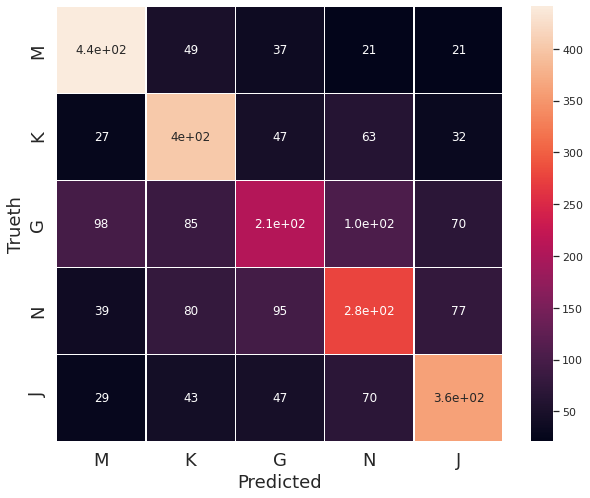

In [56]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = ((10,8)))
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_valid, predictions)
sns.heatmap(cm, annot = True , linewidth = 0.5, linecolor = 'white')
ax.set_xticks([0.5, 1.5, 2.5, 3.5, 4.5])
ax.set_xticklabels(['M', 'K', 'G', 'N', 'J'], fontsize = 18)
ax.set_yticklabels(['M', 'K', 'G', 'N', 'J'], fontsize = 18)

ax.set_xlabel('Predicted', fontsize = 18)
ax.set_ylabel('Trueth'   , fontsize = 18)
plt.show()

## SAVE MODEL
In practice, after finding the most predictive model, it will be deployed. Generally, the engeneering departments are involved with this  step. Hence, It would be efficient to pass the model to them in an managable way. There are two standard way to save our model. First option would be Pickle package and the second one is joblib. One should note that, joblib is usually significantly faster on large numpy arrays because it has a special handling for the array buffers of the numpy datastructure. 

In [2]:
import joblib

In [ ]:
filename = 'Nlp.sav'
joblib.dump(LGRF, filename)